<a href="https://colab.research.google.com/github/DanieleCecca/Interview-ArgoVision/blob/master/Classification_interview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificazione photos-sketch-cartoon

## Imports e environment setup

In [1]:
!pip install opencv-python -q

In [2]:
!git clone https://github.com/DanieleCecca/Interview-ArgoVision.git

Cloning into 'Interview-ArgoVision'...
remote: Enumerating objects: 10044, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 10044 (delta 5), reused 0 (delta 0), pack-reused 10032 (from 1)
Receiving objects: 100% (10044/10044), 176.80 MiB | 16.52 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (9994/9994), done.


In [3]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wasserstein_distance

import torch
from torch import nn

## Costanti

In [46]:
DATA_TRAINING="/content/Interview-ArgoVision/PACS/photo"

In [47]:
DATA_TEST_CARTOON="/content/Interview-ArgoVision/PACS/cartoon"

In [48]:
DATA_TEST_SKETCH="/content/Interview-ArgoVision/PACS/sketch"

## Funzione

In [49]:
#All'interno di ogni cartella ci sono delle sotto cartelle per ogni tipo di figura.
#Quindi la label corrisponderà al nome della sotto-cartella.
def create_dataframe(data_path):
  dict_data={'path':[], 'label':[]}
  for folder in os.listdir(data_path):
    folder_path=os.path.join(data_path,folder)
    for file in os.listdir(folder_path):
      file_path=os.path.join(folder_path,file)
      dict_data['path'].append(file_path)
      dict_data['label'].append(folder)
  return pd.DataFrame(dict_data)


In [50]:
def visualize_images(data,rows=5,columns=4):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, columns*rows +1):
        img_path=data['path'].sample(1).iloc[0]
        img=cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.tight_layout()
    plt.show()

In [51]:
def info_images(data):
    info = {
        'img_path': [],
        'shape': []
    }
    for img_path in data['path']:
        img=cv2.imread(img_path)

        info['img_path'].append(img_path)
        info['shape'].append(img.shape)

    return info

In [52]:
def get_rgb_distributions(img_path):
  img = cv2.imread(img_path)
  if img is None:
      print(f"Errore durante il caricamento dell'immagine: {img_path}")
      return None, None, None

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  r = img[:, :, 0].flatten()
  g = img[:, :, 1].flatten()
  b = img[:, :, 2].flatten()

  bins=256
  # Calcola istogrammi normalizzati (distribuzioni)
  hist_r, _ = np.histogram(r, bins=bins, range=(0, 256), density=True)
  hist_g, _ = np.histogram(g, bins=bins, range=(0, 256), density=True)
  hist_b, _ = np.histogram(b, bins=bins, range=(0, 256), density=True)

  return hist_r, hist_g, hist_b


In [53]:
def compute_wasserstein_to_group(data,group_rgb_hists):
  data['wasserstein_distance'] = None
  for index, row in data.iterrows():
    label = row['label']
    group_hist = group_rgb_hists.get(label)
    if group_hist is None:
        data.loc[index, "wasserstein_distance"] = np.nan
        continue

    dist_r = wasserstein_distance(row['hist_r'], group_hist[0])
    dist_g = wasserstein_distance(row['hist_g'], group_hist[1])
    dist_b = wasserstein_distance(row['hist_b'], group_hist[2])

    data.loc[index, "wasserstein_distance"] = dist_r + dist_g + dist_b
  return data

## Data

### Data exploration

Creo 3 dataframe per il set di training e i due set di test.Il df avrà due colonne:
- **path**: percorso dell'immagine
- **label**: label associata all'immagine

In [54]:
df_training=create_dataframe(DATA_TRAINING)
df_test_cartoon=create_dataframe(DATA_TEST_CARTOON)
df_test_sketch=create_dataframe(DATA_TEST_SKETCH)

In [55]:
df_training.head(3)

,path,label
0,/content/Interview-ArgoVision/PACS/photo/guita...,guitar
1,/content/Interview-ArgoVision/PACS/photo/guita...,guitar
2,/content/Interview-ArgoVision/PACS/photo/guita...,guitar


Verifico la quantità di dati che ho a disposizione.I dati a disposizione non sono tantissimi quindi adotterò sicuramente delle tecniche di data augmentation

In [56]:
print(f"Shape traininf set: {df_training.shape}")
print(f"Shape test cartoon set: {df_test_cartoon.shape}")
print(f"Shape test sketch set: {df_test_sketch.shape}")

Shape traininf set: (1670, 2)
Shape test cartoon set: (2344, 2)
Shape test sketch set: (3929, 2)


Verifico che tutte le immagini abbiano la stessa dimensione

In [57]:
info_training=info_images(df_training)
info_test_cartoon=info_images(df_test_cartoon)
info_test_sketch=info_images(df_test_sketch)

In [58]:
print(f"Shape delle immagini nel training set: {np.unique(info_training['shape'])}")
print(f"Shape delle immagini nel test cartoon set: {np.unique(info_test_cartoon['shape'])}")
print(f"Shape delle immagini nel test sketch set: {np.unique(info_test_sketch['shape'])}")

Shape delle immagini nel training set: [  3 227]
Shape delle immagini nel test cartoon set: [  3 227]
Shape delle immagini nel test sketch set: [  3 227]


Poichè le label sono stringhe di tipo categorico le codifico in modo tale da associare ad ogni label un identificativo

In [59]:
labels=df_training['label'].unique()
print(f"Label nel training set:\n{len(labels)}\n{labels}")

labels=df_test_cartoon['label'].unique()
print(f"Label nel test cartoon set:\n{len(labels)}\n{labels}")

labels=df_test_sketch['label'].unique()
print(f"Label nel test sketch set:\n{len(labels)}\n{labels}")

Label nel training set:
7
['guitar' 'dog' 'elephant' 'giraffe' 'horse' 'person' 'house']
Label nel test cartoon set:
7
['guitar' 'dog' 'elephant' 'giraffe' 'horse' 'person' 'house']
Label nel test sketch set:
7
['guitar' 'dog' 'elephant' 'giraffe' 'horse' 'person' 'house']


In [60]:
label2id={label:i for i,label in enumerate(labels)}
id2label={i:label for i,label in enumerate(labels)}

print(f"Label2id:\n{label2id}")
print(f"Id2label:\n{id2label}")

Label2id:
{'guitar': 0, 'dog': 1, 'elephant': 2, 'giraffe': 3, 'horse': 4, 'person': 5, 'house': 6}
Id2label:
{0: 'guitar', 1: 'dog', 2: 'elephant', 3: 'giraffe', 4: 'horse', 5: 'person', 6: 'house'}


In [61]:
df_training['label']=df_training['label'].map(label2id)
df_test_cartoon['label']=df_test_cartoon['label'].map(label2id)
df_test_sketch['label']=df_test_sketch['label'].map(label2id)

In [62]:
df_training.head(3)

,path,label
0,/content/Interview-ArgoVision/PACS/photo/guita...,0
1,/content/Interview-ArgoVision/PACS/photo/guita...,0
2,/content/Interview-ArgoVision/PACS/photo/guita...,0


Visualizzo le immagini per tutti i set di dati

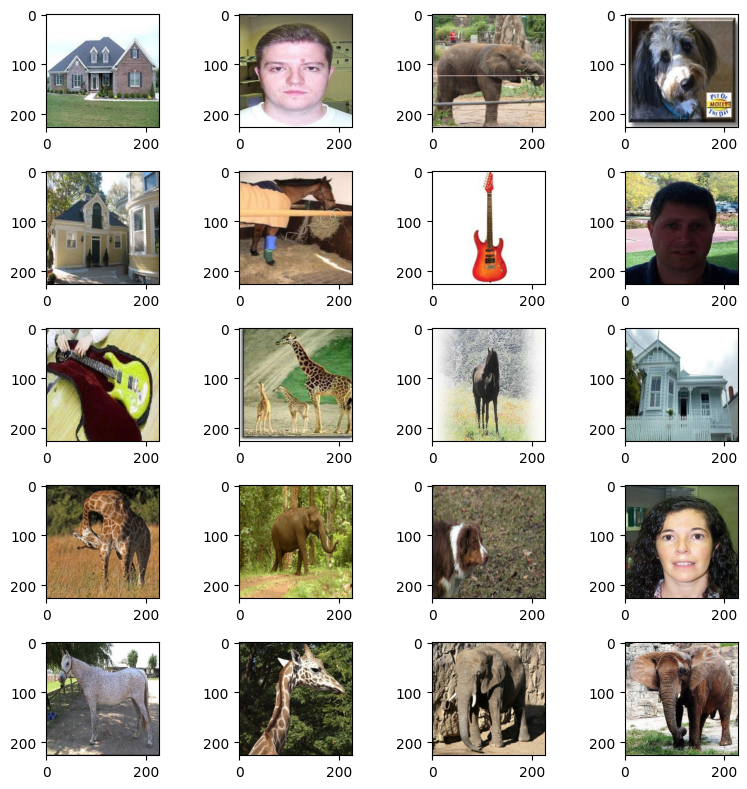

In [63]:
visualize_images(df_training)

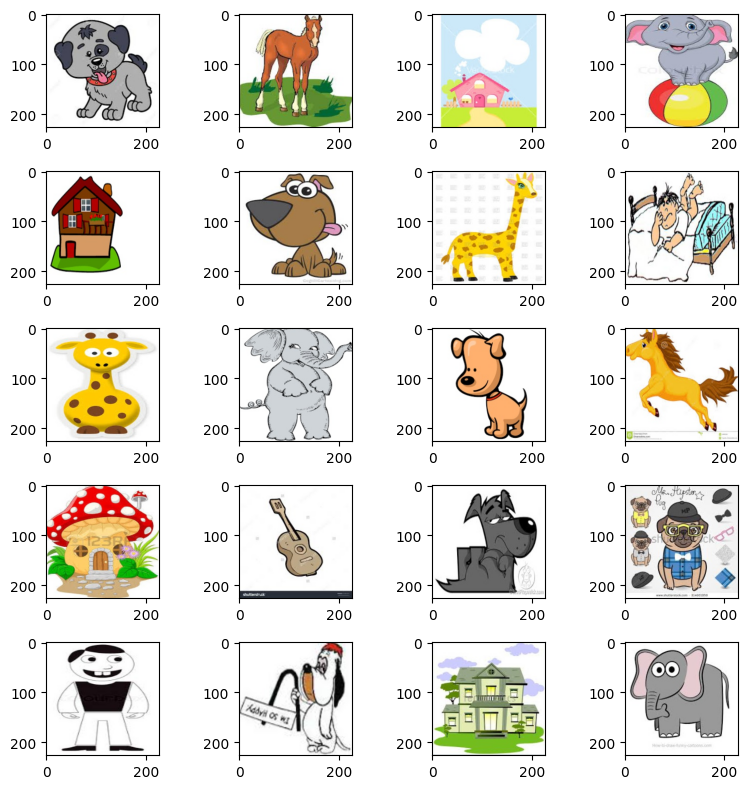

In [64]:
visualize_images(df_test_cartoon)

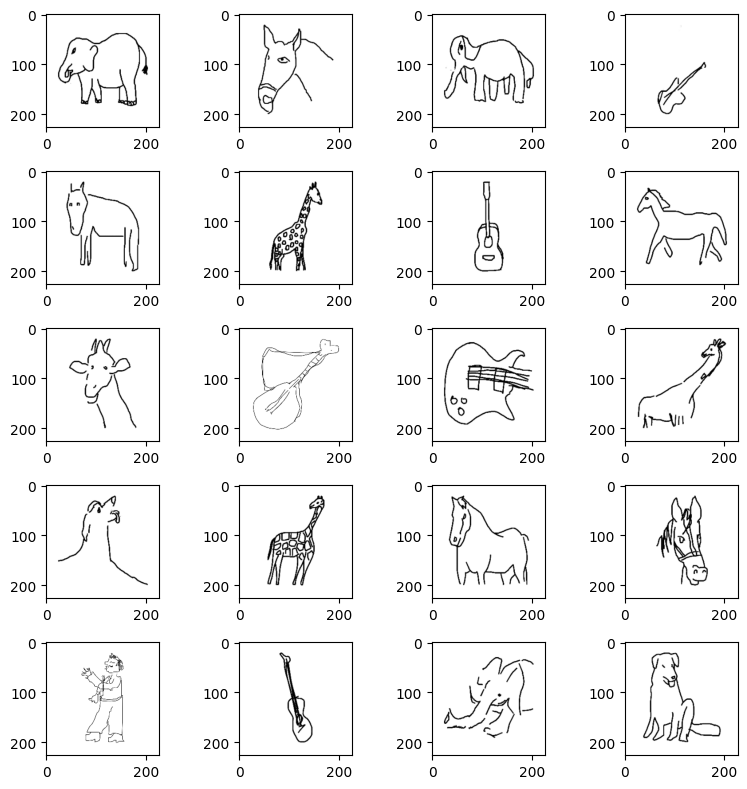

In [65]:
visualize_images(df_test_sketch)

Controllo quante label ho per ogni classe per verificare se il dataset è sbilanciato o meno

Numero di immagini per label:
       path
label      
0       186
1       189
2       202
3       182
4       199
5       432
6       280


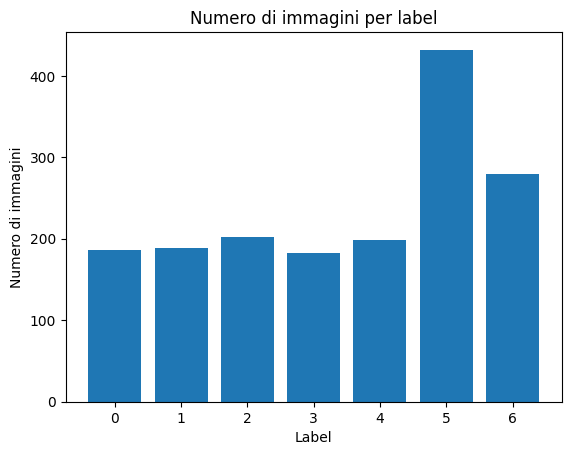

In [66]:
count_labels=df_training.groupby('label').count()
print(f"Numero di immagini per label:\n{count_labels}")

plt.bar(count_labels.index, count_labels['path'])
plt.xlabel('Label')
plt.ylabel('Numero di immagini')
plt.title('Numero di immagini per label')
plt.show()

Numero di immagini per label:
       path
label      
0       135
1       389
2       457
3       346
4       324
5       405
6       288


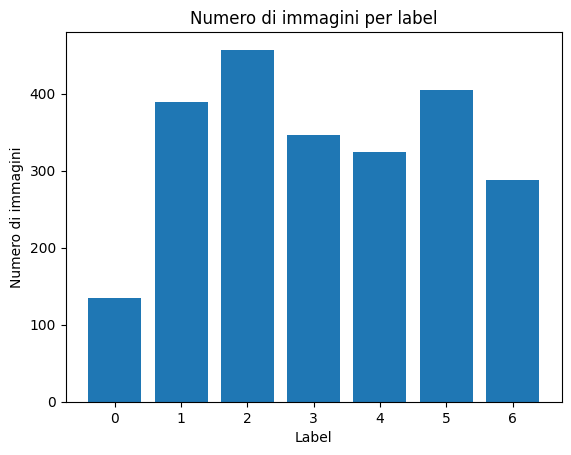

In [67]:
count_labels=df_test_cartoon.groupby('label').count()
print(f"Numero di immagini per label:\n{count_labels}")

plt.bar(count_labels.index, count_labels['path'])
plt.xlabel('Label')
plt.ylabel('Numero di immagini')
plt.title('Numero di immagini per label')
plt.show()

Numero di immagini per label:
       path
label      
0       608
1       772
2       740
3       753
4       816
5       160
6        80


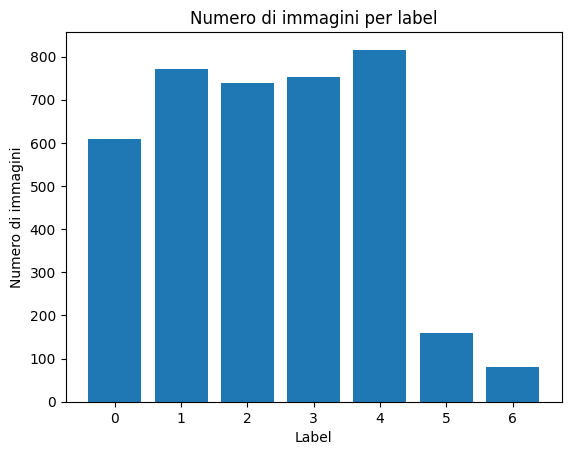

In [68]:
count_labels=df_test_sketch.groupby('label').count()
print(f"Numero di immagini per label:\n{count_labels}")

plt.bar(count_labels.index, count_labels['path'])
plt.xlabel('Label')
plt.ylabel('Numero di immagini')
plt.title('Numero di immagini per label')
plt.show()

Controllo che non ci siano outliers, che nel mio caso potrebbero essere sia immagini con label errate sia immagini corrotte.

Un metodo semplice per individuarli potrebbe essere quello di confrontare le distribuzione dei 3 canali rgb per ogni immagine con la distribuzione media.

In questo caso ho deciso di utlizzare come metodo per confrontare le due distribuzioni: **Wasserstein**


Differenze tra metrica di Wasserstein e divergenza di Kullback-Leibler (KL)

Quando si considerano i vantaggi della metrica di Wasserstein rispetto alla divergenza di Kullback-Leibler (KL), il più evidente è che **Wasserstein è una metrica**, mentre la KL **non lo è**. Infatti, la KL **non è simmetrica** (cioè, in generale, D<sub>KL</sub>(P‖Q) ≠ D<sub>KL</sub>(Q‖P)) e **non soddisfa la disuguaglianza triangolare** (ovvero, in generale, D<sub>KL</sub>(R‖P) ≤ D<sub>KL</sub>(Q‖P) + D<sub>KL</sub>(R‖Q) non vale).

[spiegazione](https://stats.stackexchange.com/questions/295617/what-is-the-advantages-of-wasserstein-metric-compared-to-kullback-leibler-diverg)

Calcolo per ogni immagine le distribuzioni r g b

In [69]:
# Initialize columns to hold arrays
df_training['hist_r'] = None
df_training['hist_g'] = None
df_training['hist_b'] = None

for index, row in df_training.iterrows():
  path = row['path']
  hist_r, hist_g, hist_b = get_rgb_distributions(path)
  df_training.at[index, 'hist_r'] = hist_r
  df_training.at[index, 'hist_g'] = hist_g
  df_training.at[index, 'hist_b'] = hist_b
  print(f"Processing image {path}")

Processing image /content/Interview-ArgoVision/PACS/photo/guitar/063_0090.jpg
Processing image /content/Interview-ArgoVision/PACS/photo/guitar/063_0023.jpg
Processing image /content/Interview-ArgoVision/PACS/photo/guitar/n03272010_9557.jpg
Processing image /content/Interview-ArgoVision/PACS/photo/guitar/063_0024.jpg
Processing image /content/Interview-ArgoVision/PACS/photo/guitar/n02676566_4189.jpg
Processing image /content/Interview-ArgoVision/PACS/photo/guitar/n03467517_7007.jpg
Processing image /content/Interview-ArgoVision/PACS/photo/guitar/063_0048.jpg
Processing image /content/Interview-ArgoVision/PACS/photo/guitar/n02676566_7844.jpg
Processing image /content/Interview-ArgoVision/PACS/photo/guitar/063_0113.jpg
Processing image /content/Interview-ArgoVision/PACS/photo/guitar/n02676566_4469.jpg
Processing image /content/Interview-ArgoVision/PACS/photo/guitar/063_0040.jpg
Processing image /content/Interview-ArgoVision/PACS/photo/guitar/n03272010_392.jpg
Processing image /content/Int

Calcolo le distribuzioni medie r g b per ogni label

In [70]:
group_rgb_hists = {}
for label in df_training['label'].unique():
    subset = df_training[df_training['label'] == label]
    valid = subset.dropna(subset=['hist_r', 'hist_g', 'hist_b'])

    hist_r_avg = np.mean(valid['hist_r'].to_list(), axis=0)
    hist_g_avg = np.mean(valid['hist_g'].to_list(), axis=0)
    hist_b_avg = np.mean(valid['hist_b'].to_list(), axis=0)

    group_rgb_hists[label] = (hist_r_avg, hist_g_avg, hist_b_avg)

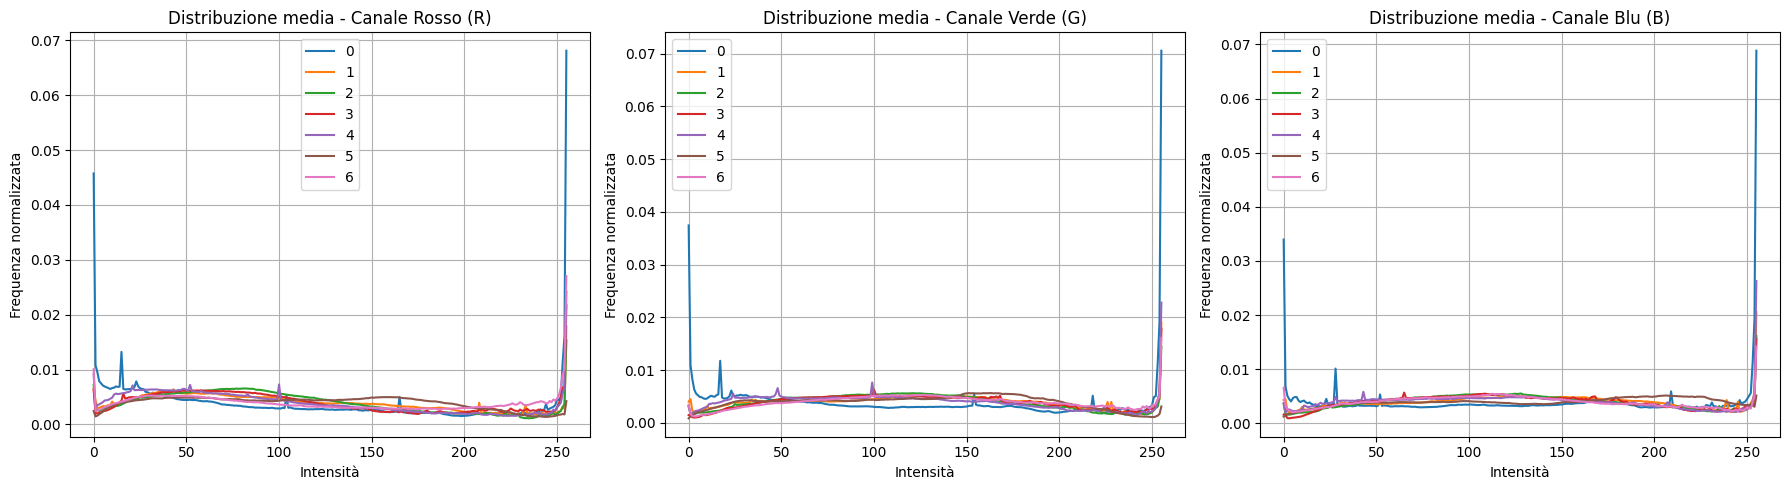

In [71]:
bins = np.arange(256)

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
for label, (r, _, _) in group_rgb_hists.items():
    plt.plot(bins[:len(r)], r, label=str(label))
plt.title("Distribuzione media - Canale Rosso (R)")
plt.xlabel("Intensità")
plt.ylabel("Frequenza normalizzata")
plt.legend()
plt.grid(True)

# Green channel
plt.subplot(1, 3, 2)
for label, (_, g, _) in group_rgb_hists.items():
    plt.plot(bins[:len(g)], g, label=str(label))
plt.title("Distribuzione media - Canale Verde (G)")
plt.xlabel("Intensità")
plt.ylabel("Frequenza normalizzata")
plt.legend()
plt.grid(True)

# Blue channel
plt.subplot(1, 3, 3)
for label, (_, _, b) in group_rgb_hists.items():
    plt.plot(bins[:len(b)], b, label=str(label))
plt.title("Distribuzione media - Canale Blu (B)")
plt.xlabel("Intensità")
plt.ylabel("Frequenza normalizzata")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Calcolo compute_wasserstein_to_group per ogni immagine

In [72]:
df_training=compute_wasserstein_to_group(df_training,group_rgb_hists)

Trovo e visualizzo gli outliers

Outlier trovati: 17


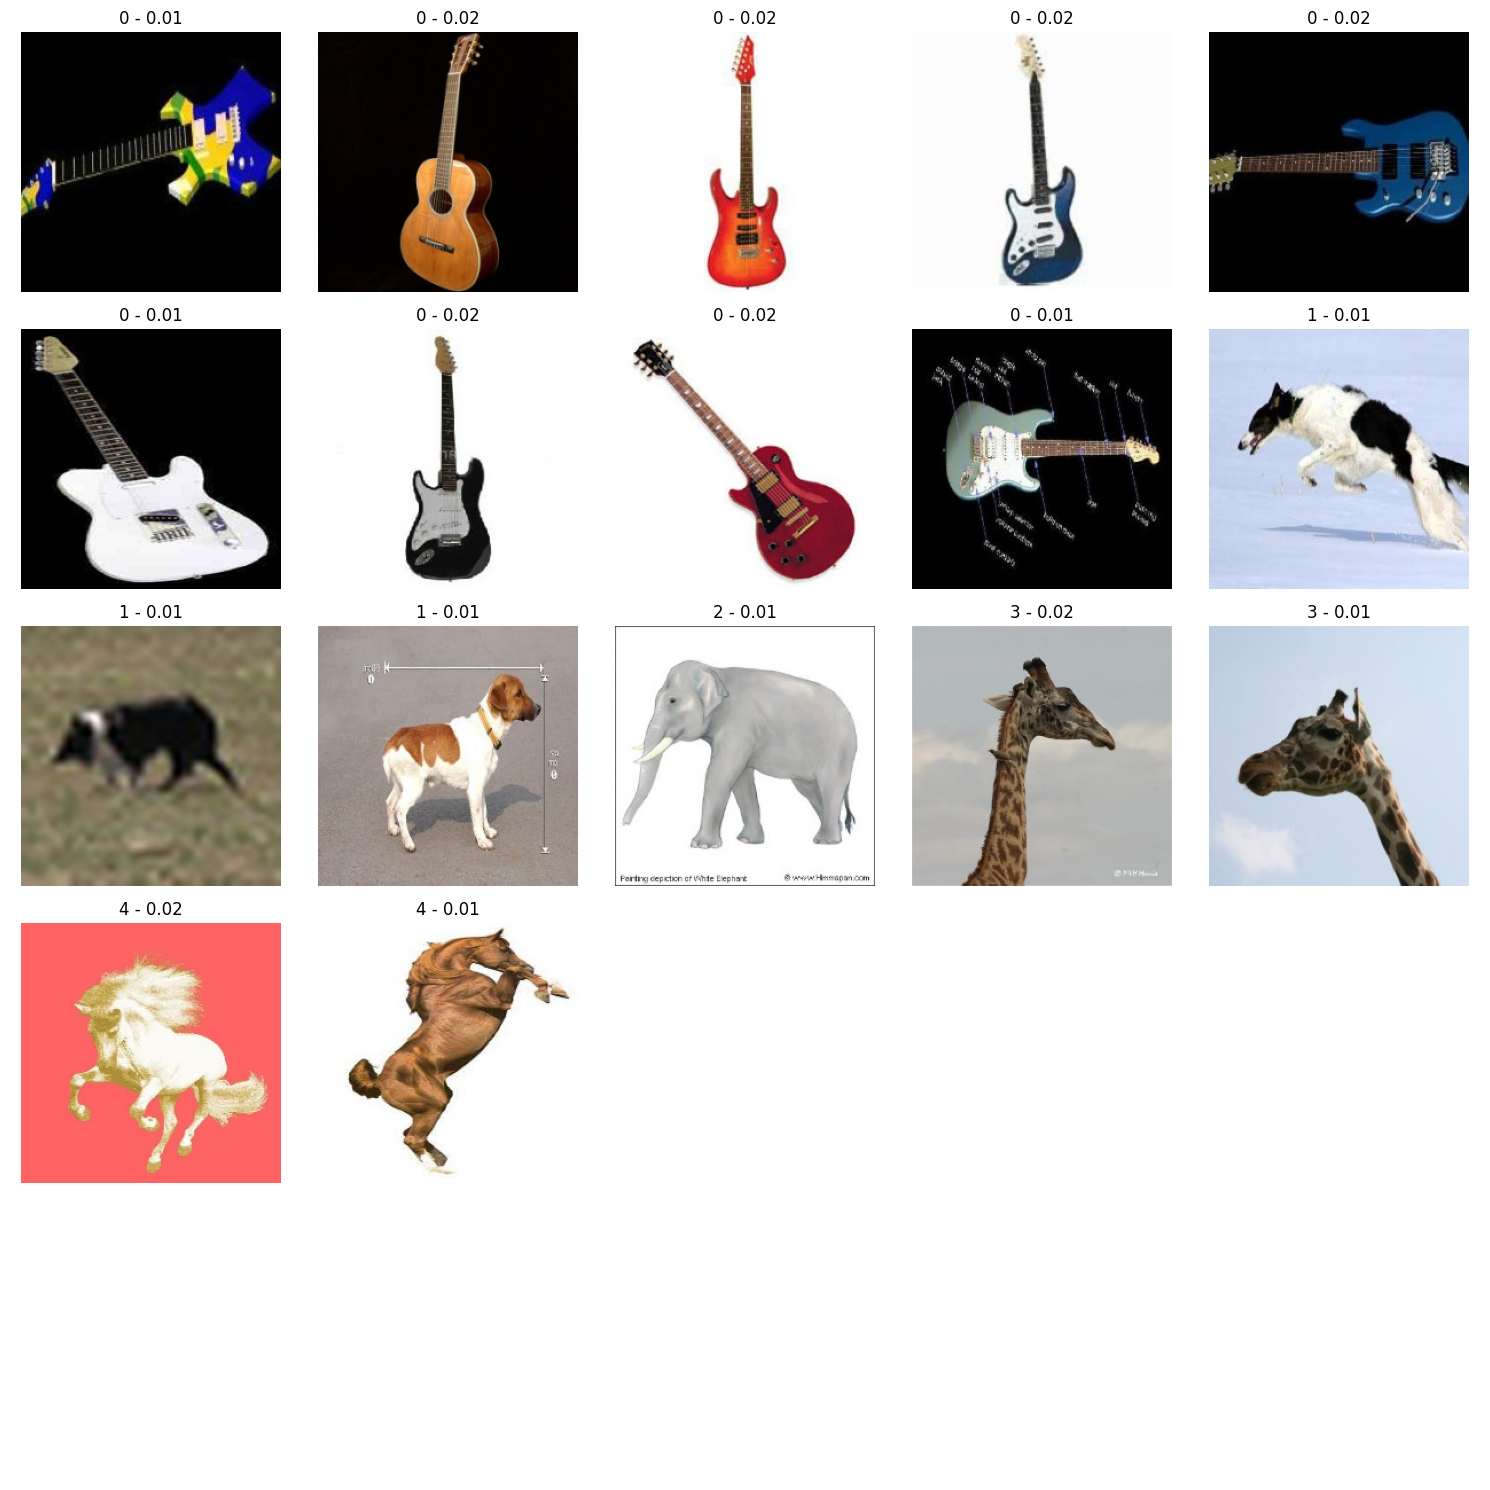

In [73]:
# Threshold e outlier
threshold = df_training['wasserstein_distance'].quantile(0.99)
outliers = df_training[df_training['wasserstein_distance'] > threshold]
print(f"Outlier trovati: {len(outliers)}")

# Numero immagini da plottare
max_imgs = min(len(outliers), 25)
rows = int(np.ceil(np.sqrt(max_imgs)))
cols = rows

# Plot
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
axes = axes.flatten()

for i, (_, row) in enumerate(outliers.head(max_imgs).iterrows()):
    img = cv2.imread(row['path'])
    if img is None:
        axes[i].set_title("Errore lettura")
        axes[i].axis('off')
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[i].imshow(img)
    axes[i].set_title(f"{row['label']} - {row['wasserstein_distance']:.2f}")
    axes[i].axis('off')

# Nasconde i subplot vuoti
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Class Dataset

Creo la classe di tipo dataset che mi servirà per gestire il preprocessing e il loading dei dati all'interno della rete.

In [ ]:
class DatasetPhotos(torch.utils.data.Dataset):
  def __init__(self,df,transform=None):
    self.df=df
    self.transform=transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    img_path=self.df.iloc[idx]['path']
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    label=self.df.iloc[idx]['label']
    if self.transform:
      img=self.transform(img)

    x = torch.tensor(img).float() / 255.0
    y = torch.tensor(label).long()

    return x,y

In [ ]:
dataset_training=DatasetPhotos(df_training)
dataset_test_cartoon=DatasetPhotos(df_test_cartoon)
dataset_test_sketch=DatasetPhotos(df_test_sketch)

In [ ]:
img, label=dataset_training.__getitem__(1)
print(img.shape)
print(label)

torch.Size([227, 227, 3])
tensor(0, dtype=torch.int16)


## Classification models

### CNN

#### Building block

In [81]:
class CNNModel(torch.nn.Module):
  def __init__(self,num_conv2d,num_class):
    super().__init__()

    self.num_conv2d=num_conv2d
    self.num_class=num_class


    self.conv1 = nn.Conv2d(3, 32, kernel_size=11, stride=2, dilation=2)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(32,64,5,padding='same')
    self.maxpool=nn.MaxPool2d(2)

    self.seq1=nn.Sequential()
    for i in range(self.num_conv2d):
        self.seq1.add_module(f"conv{i+2}",nn.Conv2d(64,64,3,padding='same'))
        self.seq1.add_module(f"relu{i+2}", nn.ReLU())


    self.seq2=nn.Sequential()
    for i in range(self.num_conv2d):
        self.seq2.add_module(f"conv{i+self.num_conv2d}",nn.Conv2d(64,128,3,padding='same'))
        self.seq2.add_module(f"relu{i+self.num_conv2d}", nn.ReLU())

    self.seq3=nn.Sequential()
    for i in range(self.num_conv2d):
        self.seq3.add_module(f"conv{i+self.num_conv2d*2}",nn.Conv2d(128,256,3,padding='same'))
        self.seq3.add_module(f"relu{i+self.num_conv2d*2}", nn.ReLU())

    self.seq4=nn.Sequential()
    for i in range(self.num_conv2d):
        self.seq4.add_module(f"conv{i+self.num_conv2d*3}",nn.Conv2d(256,512,3,padding='same'))
        self.seq4.add_module(f"relu{i+self.num_conv2d*3}", nn.ReLU())

    self.seq5=nn.Sequential()
    for i in range(self.num_conv2d):
        self.seq5.add_module(f"conv{i+self.num_conv2d*4}",nn.Conv2d(512,1024,3,padding='same'))
        self.seq5.add_module(f"relu{i+self.num_conv2d*4}", nn.ReLU())

    self.flatten=nn.Flatten()
    self.fc1=nn.Linear(1024,512)
    self.relu2=nn.ReLU()
    self.fc2=nn.Linear(512,self.num_class)
    self.softmax=nn.Softmax()


  def forward(self,x):
    # x shape:[B,C,H,W]
    x=self.conv1(x)
    x=self.relu1(x)
    x=self.conv2(x)
    x=self.maxpool(x)

    x=self.seq1(x)
    x=self.maxpool(x)

    x=self.seq2(x)
    x=self.maxpool(x)

    x=self.seq3(x)
    x=self.maxpool(x)

    x=self.seq4(x)
    x=self.maxpool(x)

    x=self.seq5(x)


    x=self.flatten(x)

    x=self.fc1(x)
    x=self.relu2(x)
    x=self.fc2(x)
    #x=self.softmax(x)

    return x

In [83]:
model= CNNModel(num_conv2d=3,num_class=len(labels))
# Count the number of parameters in the model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f'Number of parameters in the model: {num_params}')

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(11, 11), stride=(2, 2), dilation=(2, 2))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (seq1): Sequential(
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (relu2): ReLU()
    (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (relu3): ReLU()
    (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (relu4): ReLU()
  )
  (seq2): Sequential(
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (relu3): ReLU()
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (relu4): ReLU()
    (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (relu5): ReLU()
  )
  (seq3): Sequential(
    (conv6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), paddin

###ResNet Model

#### Bulding blocks

In [86]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,next_block_res=True):
        super().__init__()
        self.next_block_res=next_block_res

        self.groupNormalization1=nn.GroupNorm(num_groups=in_channels,num_channels=in_channels)
        self.relu1=nn.ReLU()
        self.conv1=nn.Conv2d(in_channels,out_channels,kernel_size=kernel_size,padding='same')
        self.conv2=nn.Conv2d(in_channels,out_channels,kernel_size=1,padding='same')
        self

    def forward(self,x):
        shortcut=x
        x=self.groupNormalization1(x)
        x=self.relu1(x)
        x=self.conv1(x)
        x=self.groupNormalization2(x)
        x=self.relu2(x)
        x=self.conv1(x)

        if shortcut.shape[-1]!=x.shape[-1]:
            shortcut=self.conv2(shortcut)
        x=x+shortcut

        if(self.next_block_res == False):
          x = self.ReLU()(x)

        return x


In [84]:
class ResNetModel(nn.Module):
    def __init__(self, num_conv2d, num_class):
        super().__init__()

        self.num_conv2d = num_conv2d
        self.num_class = num_class

        self.initial = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=11, stride=2, dilation=2),
            nn.ReLU()
        )

        self.seq1 = nn.Sequential()
        for i in range(num_conv2d):
            self.seq1.add_module(f"res2_{i}", ResidualBlock(32 if i == 0 else 64, 64, 5))
            self.seq1.add_module(f"relu2_{i}", nn.ReLU())
        self.seq1.add_module("pool1", nn.MaxPool2d(2))

        self.seq2 = nn.Sequential()
        for i in range(num_conv2d):
            self.seq2.add_module(f"res3_{i}", ResidualBlock(64 if i == 0 else 128, 128, 3))
            self.seq2.add_module(f"relu3_{i}", nn.ReLU())

        self.seq3 = nn.Sequential()
        for i in range(num_conv2d):
            self.seq3.add_module(f"res4_{i}", ResidualBlock(128 if i == 0 else 256, 256, 3))
            self.seq3.add_module(f"relu4_{i}", nn.ReLU())

        self.seq4 = nn.Sequential()
        for i in range(num_conv2d):
            self.seq4.add_module(f"res5_{i}", ResidualBlock(256 if i == 0 else 512, 512, 3))
            self.seq4.add_module(f"relu5_{i}", nn.ReLU())

        self.seq5 = nn.Sequential()
        for i in range(num_conv2d):
            self.seq5.add_module(f"res6_{i}", ResidualBlock(512 if i == 0 else 1024, 1024, 3, next_block_res=False))
            self.seq5.add_module(f"relu6_{i}", nn.ReLU())

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(512, num_class)

    def forward(self, x):
        x = self.initial(x)
        x = self.seq1(x)
        x = self.seq2(x)
        x = self.seq3(x)
        x = self.seq4(x)
        x = self.seq5(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.relu2(x)
        x = self.fc2(x)
        return x


In [87]:
model= ResNetModel(num_conv2d=4,num_class=len(labels))
# Count the number of parameters in the model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f'Number of parameters in the model: {num_params}')

ResNetModel(
  (initial): Sequential(
    (0): Conv2d(3, 32, kernel_size=(11, 11), stride=(2, 2), dilation=(2, 2))
    (1): ReLU()
  )
  (seq1): Sequential(
    (res2_0): ResidualBlock(
      (groupNormalization1): GroupNorm(32, 32, eps=1e-05, affine=True)
      (relu1): ReLU()
      (conv1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (conv2): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
    )
    (relu2_0): ReLU()
    (res2_1): ResidualBlock(
      (groupNormalization1): GroupNorm(64, 64, eps=1e-05, affine=True)
      (relu1): ReLU()
      (conv1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
    )
    (relu2_1): ReLU()
    (res2_2): ResidualBlock(
      (groupNormalization1): GroupNorm(64, 64, eps=1e-05, affine=True)
      (relu1): ReLU()
      (conv1): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (conv2): Conv2d(64, 

### Segformer inspired model

### Building block

In [21]:
class MixFFN(nn.Module):
  def __init__(self,dim_projected, dropout):
    super().__init__()
    self.dim_projected=dim_projected#dimension of a flatted patch (es 32)
    self.hidden_dim=dim_projected*2

    self.fc1 = nn.Linear(self.dim_projected, self.hidden_dim)
    self.dconv1 = nn.Conv2d(self.hidden_dim,
                            out_channels=self.hidden_dim,
                            kernel_size=3,
                            padding='same',
                            groups=self.hidden_dim)
    self.gelu = nn.GELU()
    self.drop = nn.Dropout(dropout)
    self.fc2 = nn.Linear(self.hidden_dim, self.dim_projected)

  def forward(self, x):
      # x shape: [B, N, D] D dimension embeddding es(32 first case)
      B, N, D = x.shape
      H = W = int(N ** 0.5)

      x = self.fc1(x)  # [B, N, 2D]
      x = x.transpose(1, 2).reshape(B, self.hidden_dim, H, W)  # [B, 2D, H, W]
      x = self.dconv1(x)  # [B, 2D, H, W]
      x = self.gelu(x)
      x = x.reshape(B, self.hidden_dim, N).transpose(1, 2)  # [B, N, 2D]
      x = self.drop(x)
      x = self.fc2(x)  # [B, N, D]
      return x




In [30]:
class Transformer(nn.Module):
  def __init__(self,dim,num_heads,dropout):
    super().__init__()

    self.norm1 = nn.LayerNorm(dim)
    self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, dropout=dropout, batch_first=True)
    self.norm2 = nn.LayerNorm(dim)
    self.mlp = MixFFN(dim, dropout)

  def forward(self,x):
      # x shape: [B, N, D]
      x1 = self.norm1(x)
      attn_out, _ = self.attn(x1, x1, x1)
      x2 = x + attn_out  # skip connection
      x3 = self.norm2(x2)
      x4 = self.mlp(x3)
      return x4 + x2  # final skip



In [23]:
class HierarchicalViTEncoder(nn.Module):
    def __init__(self, in_channels=3, transformer_layers=4, dropout=0.2):
        super().__init__()

        self.embed_dims = [32, 64, 128, 256]
        self.kernel_sizes = [7, 3, 3, 3]
        self.strides = [4, 2, 2, 2]

        self.stages = nn.ModuleList()
        self.transformers = nn.ModuleList()

        #patch creation
        current_channels = in_channels
        for i in range(len(self.embed_dims)):
            conv = nn.Conv2d(current_channels, self.embed_dims[i],
                             kernel_size=self.kernel_sizes[i],
                             stride=self.strides[i],
                             padding=self.kernel_sizes[i] // 2)
            self.stages.append(conv)
            current_channels = self.embed_dims[i]

            # Ogni stage ha i suoi transformer layer
            transformer_blocks = nn.Sequential()
            for _ in range(transformer_layers):
                block = Transformer(dim=self.embed_dims[i], num_heads=4, dropout=dropout)
                transformer_blocks.append(block)

    def forward(self, x):
        features = []
        for i in range(len(self.embed_dims)):
            x = self.stages[i](x)  # [B, C, H, W]
            B, C, H, W = x.shape
            x_reshaped = x.flatten(2).transpose(1, 2)  # [B, H*W, C]
            x_reshaped = self.transformers[i](x_reshaped)  # Transformer expects [B, N, D]
            x_out = x_reshaped.transpose(1, 2).reshape(B, C, H, W)
            features.append(x_out)
        return features

In [41]:
class ClassDecoder(nn.Module):
    def __init__(self, in_channels_list, num_classes=7, target_size=(16, 16)):
        super().__init__()
        self.target_size = target_size
        self.num_classes = num_classes

        self.channel_projectors = nn.ModuleList()
        self.upsamplers = nn.ModuleList()
        self.gelu=nn.GELU()
        for in_ch in in_channels_list:
            # Porta a 256 canali
            self.channel_projectors.append(nn.Conv2d(in_ch, 256, kernel_size=1))
            # Upsample a target_size
            self.upsamplers.append(
                nn.Upsample(size=target_size, mode='bilinear', align_corners=False)
            )

        # Dopo concatenazione: [B, 256*4, 64, 64] → flatten → Linear
        self.fc1 = nn.Linear(256 * 4 * target_size[0] * target_size[1], 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self,features):
        # features: lista di 4 tensori [B, C_i, H_i, W_i]
        projected_features = []

        for i, x in enumerate(features):
            x = self.channel_projectors[i](x)         # [B, 256, H_i, W_i]
            x = self.upsamplers[i](x)                 # [B, 256, 64, 64]
            projected_features.append(x)

        x = torch.cat(projected_features, dim=1)      # [B, 1024, 64, 64]
        x = x.view(x.size(0), -1)                     # [B, 1024*64*64]
        x = self.gelu(self.fc1(x))                       # [B, 128]
        x = self.fc2(x)                               # [B, num_classes]
        x = self.softmax(x)                           # [B, num_classes]

        return x

### Segformer model

In [42]:
class SegformerClass(nn.Module):
  def __init__(self,num_class=7):
    super().__init__()
    self.encoder=HierarchicalViTEncoder()
    self.decoder=ClassDecoder([32, 64, 128, 256],num_classes=num_class)

  def forward(self,x):
    features=self.encoder(x)
    x=self.decoder(features)

    return x


In [43]:
model= SegformerClass()
# Count the number of parameters in the model
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f'Number of parameters in the model: {num_params}')


SegformerClass(
  (encoder): HierarchicalViTEncoder(
    (stages): ModuleList(
      (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (transformers): ModuleList()
  )
  (decoder): ClassDecoder(
    (channel_projectors): ModuleList(
      (0): Conv2d(32, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (2): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
      (3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (upsamplers): ModuleList(
      (0-3): 4 x Upsample(size=(16, 16), mode='bilinear')
    )
    (gelu): GELU(approximate='none')
    (fc1): Linear(in_features=262144, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=7